/usr/local/lib/python3.9/dist-packages/albumentations/core/bbox_utils.py


```
def check_bbox(bbox):
    """Check if bbox boundaries are in range 0, 1 and minimums are lesser then maximums"""
   #my added block 
    bbox=list(bbox)
    for i in range(4):
      if (bbox[i]<0) :
        bbox[i]=0
      elif (bbox[i]>1) :
        bbox[i]=1
    bbox=tuple(bbox)
   #end of block
   #rest of the code as it is
```

**Restart runtime to apply changes.**


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import time
import shutil
import torch.nn as nn
import torchvision
import cv2
from google.colab.patches import cv2_imshow
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler
from torchvision import utils
from albumentations import (HorizontalFlip, ShiftScaleRotate, VerticalFlip, Normalize, Flip,
                            Compose, GaussNoise)
from torchvision.transforms import ToTensor
from albumentations.pytorch.transforms import ToTensorV2
from torchvision import transforms

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
train_json = "/content/drive/My Drive/thyroid_nodule_detection/Freehand to Bounding Box Conversion Fix/fixed_labels/cropped_dataset/dataset_after_augmented_2/train/cropped_labels.json"
train_dir = "/content/drive/My Drive/thyroid_nodule_detection/Freehand to Bounding Box Conversion Fix/fixed_labels/cropped_dataset/dataset_after_augmented_2/train/cropped_images"

validation_json = "/content/drive/My Drive/thyroid_nodule_detection/Freehand to Bounding Box Conversion Fix/fixed_labels/cropped_dataset/dataset_after_augmented_2/validation/cropped_labels.json"
validation_dir = "/content/drive/My Drive/thyroid_nodule_detection/Freehand to Bounding Box Conversion Fix/fixed_labels/cropped_dataset/dataset_after_augmented_2/validation/cropped_images"

In [ ]:
temp_train_df = pd.read_json(train_json)
temp_validation_df = pd.read_json(validation_json)

print(f'shape of train dataframe is {temp_train_df.shape}')
print(f'shape of validation dataframe is {temp_validation_df.shape}')

In [ ]:
#dataset distribution dummy code
valid_negative = 0
valid_positve = 0
for valid in temp_train_df["cases"]:
  if valid["labels"][0] <= 3:
      valid_negative = valid_negative + 1
  else:
      valid_positve = valid_positve + 1
print("train pos", valid_positve)
print("train neg", valid_negative)
print( len(temp_train_df))


valid_negative = 0
valid_positve = 0
for valid in temp_validation_df["cases"]:
  if valid["labels"][0] <= 3:
      valid_negative = valid_negative + 1
  else:
      valid_positve = valid_positve + 1
print("valid pos", valid_positve)
print("valid neg", valid_negative)
print(len(temp_validation_df))

TEST_JSON = "/content/drive/My Drive/thyroid_nodule_detection/Freehand to Bounding Box Conversion Fix/fixed_labels/cropped_dataset/dataset_after_augmented/test/cropped_labels.json"
temp_test_df = pd.read_json(TEST_JSON)
valid_negative = 0
valid_positve = 0
for valid in temp_test_df["cases"]:
  if valid["labels"][0] <= 3:
      valid_negative = valid_negative + 1
  else:
      valid_positve = valid_positve + 1

print("test pos", valid_positve)
print("test neg", valid_negative)
print(len(temp_test_df))

print(len(temp_train_df) + len(temp_validation_df) + len(temp_test_df))

train pos 464
train neg 84
548
valid pos 52
valid neg 18
70
test pos 48
test neg 20
68
686


In [ ]:
def process_malignancy(number):
  if number <= 3:
    return 0
  else:
    return 1


def process_bbox(df):
    cases = df
    case_list = []
    for case in cases:
        temp_case = {}
        temp_case['case_id'] = case['case_id']
        temp_case['tirads'] = case['labels'][0]
        temp_case['width'] = 400 # should match cropped images
        temp_case['height'] = 350 # should match cropped images
        temp_case["labels"] = process_malignancy(temp_case['tirads'])
        if(len(case['bboxes']) == 1):
          temp_case['x'] = case['bboxes'][0][0]
          temp_case['y'] = case['bboxes'][0][1]
          temp_case['w'] = case['bboxes'][0][2]
          if len(case['bboxes'][0]) < 4:
            temp_case['h'] = 1 # bounding box should have height which is greater than 0 if invalid to no break training
          else:
            temp_case['h'] = case['bboxes'][0][3]
          case_list.append(temp_case)
        else:
          i = len(case['bboxes'])-1
          while i >= 0:
            temp_case['tirads'] = case['labels'][i]
            temp_case["labels"] = process_malignancy(temp_case['tirads'])
            temp_case['x'] = case['bboxes'][i][0]
            temp_case['y'] = case['bboxes'][i][1]
            temp_case['w'] = case['bboxes'][i][2]
            if len(case['bboxes'][0]) < 4:
              temp_case['h'] = 1 # bounding box should have height which is greater than 0 if invalid to no break training
            else:
              temp_case['h'] = case['bboxes'][i][3]
            case_list.append(temp_case)
            i -= 1         
    return pd.DataFrame(case_list)


df_train = process_bbox(temp_train_df['cases'])
df_validation = process_bbox(temp_validation_df['cases'])
print(f'shape of dataframe after prerpocessing {df_train.shape}')
print(df_train.tail())

shape of dataframe after prerpocessing (730, 9)
    case_id  tirads  width  height  labels      x      y     w     h
725   186_1       5    400     350       1   58.0  114.0  76.0  58.0
726    95_1       4    400     350       1   79.0  115.0  61.0  49.0
727    95_1       4    400     350       1   79.0  115.0  61.0  49.0
728   125_1       4    400     350       1  265.0  109.0  96.0  82.0
729   125_1       4    400     350       1  265.0  109.0  96.0  82.0


In [ ]:
import albumentations as A
def get_train_transform():
    return A.Compose([
        # A.Flip(0.5),
        # A.RandomRotate90(0.5),
        # A.MotionBlur(p=0.2),
        # A.MedianBlur(blur_limit=3, p=0.1),
        # A.Blur(blur_limit=3, p=0.1),
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc',
        'label_fields': ['labels']
    })
# define the validation transforms
def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc', 
        'label_fields': ['labels']
    })

In [ ]:
class ThyroidNoduleDataset(Dataset):
    def __init__(self, data_frame, image_dir,classes,transforms=None, phase='train'):
        super().__init__()
        self.df = data_frame
        self.image_dir = image_dir
        self.images = data_frame['case_id'].unique()
        self.transforms = transforms
        self.classes = classes

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx] + '.jpg'

        image_arr = cv2.imread(os.path.join(self.image_dir, image), cv2.IMREAD_COLOR)
        image_arr = cv2.cvtColor(image_arr, cv2.COLOR_BGR2RGB).astype(np.float32)
        image_arr /= 255.0

        image_id = str(image.split('.')[0])
        point = self.df[self.df['case_id'] == image_id]
        boxes = point[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]

        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = []

        for box in boxes: 
          labels.append(self.classes.index(str(round(self.df.get('labels').get(idx)))))
          # labels.append(self.classes.index(str(round(self.df.get('tirads').get(idx)))))

        
        
        labels = torch.as_tensor([lbl for lbl in labels])

        # suppose all instances are not crowd
        iscrowd = torch.zeros((point.shape[0],), dtype=torch.int64)

        target = {}
        target['bboxes'] = boxes
        target['labels'] = labels

        if self.transforms:
            sample = {
                'image': image_arr,
                'bboxes': target['bboxes'],
                'labels': target['labels']
            }
            sample = self.transforms(**sample)
            image = sample['image']

        target['bboxes'] = torch.stack(tuple(map(torch.tensor,
                                                zip(*sample['bboxes'])))).permute(1, 0)
        target['boxes'] = target['bboxes'] # later the model needs the 'boxes' naming so keep this copy!

        return image, target, image_id

In [ ]:
# classes = [
#     '__background__', '2', '3', '4', '5' 
# ]
classes = [
    '__background__', '0', '1' 
]
num_classes = len(classes)

In [ ]:
train_data = ThyroidNoduleDataset(df_train, train_dir,classes,get_train_transform(),  phase='train')
val_data = ThyroidNoduleDataset(df_validation, validation_dir,classes,get_valid_transform(), phase='validation')

In [ ]:
print(train_data.__getitem__(3))

(tensor([[[0.0196, 0.0000, 0.0000,  ..., 0.0314, 0.0039, 0.0431],
         [0.0392, 0.0235, 0.0157,  ..., 0.0000, 0.0078, 0.0000],
         [0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0863, 0.0039],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0196, 0.0000, 0.0000,  ..., 0.0314, 0.0039, 0.0431],
         [0.0392, 0.0235, 0.0157,  ..., 0.0000, 0.0078, 0.0000],
         [0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0863, 0.0039],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0196, 0.0000, 0.0000,  ..., 0.0314, 0.0039, 0.0431],
         [0.0392, 0.0235, 0.0157,  ..., 0.0000, 0.0078, 0.0000],
         [0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0863, 0

In [ ]:
# batching
def collate_fn(batch):
    return tuple(zip(*batch))


train_data_loader = DataLoader(
    train_data,
    batch_size=5,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    val_data,
    batch_size=5,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
def image_convert(image):
    image = image.clone().cpu().numpy()
    image = image.transpose((1, 2, 0))
    image = (image * 255).astype(np.uint8)
    return image


def plot_img(data, idx):
    print(data)
    out = data.__getitem__(idx)
    image = image_convert(out[0])
    image = np.ascontiguousarray(image)
    bb = out[1]['bboxes'].numpy()
    for i in bb:
        cv2.rectangle(image, (int(i[0]), int(i[1])), (int(i[2]), int(i[3])), (0, 255, 0), thickness=2)
    plt.figure(figsize=(10, 10))
    plt.imshow(image)


In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 162MB/s]


In [ ]:
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [ ]:
images, targets, ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [ ]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.004, momentum=0.9, weight_decay=0.0005)

# optimizer = torch.optim.Adam(params, lr=0.001)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
# helper functions to save best model

def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, checkpoint_path)
    # if it is a best model, min validation loss
    if is_best:
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(checkpoint_path, best_model_path)

In [ ]:
num_epochs = 25
train_loss_min = 0.9
total_train_loss = []

checkpoint_path = "/content/drive/My Drive/thyroid_nodule_detection/Experiment_5/checkpoints/chkpoint_apr10_with_dataset_after_new_augmented"
best_model_path = "/content/drive/My Drive/thyroid_nodule_detection/Experiment_5/checkpoints/bestmodel_apr10_with_dataset_after_new_augmented.pt"

for epoch in range(num_epochs):
    print(f'Epoch :{epoch + 1}')
    start_time = time.time()
    train_loss = []
    model.train()
    for images, targets, image_ids in train_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        train_loss.append(losses.item())        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    #train_loss/len(train_data_loader.dataset)
    epoch_train_loss = np.mean(train_loss)
    total_train_loss.append(epoch_train_loss)
    print(f'Epoch train loss is {epoch_train_loss}')
    
#     if lr_scheduler is not None:
#         lr_scheduler.step()
    
    # create checkpoint variable and add important data
    checkpoint = {
            'epoch': epoch + 1,
            'train_loss_min': epoch_train_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
    
    # save checkpoint
    save_ckp(checkpoint, False, checkpoint_path, best_model_path)
    ## TODO: save the model if validation loss has decreased
    if epoch_train_loss <= train_loss_min:
            print('Train loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(train_loss_min,epoch_train_loss))
            # save checkpoint as best model
            save_ckp(checkpoint, True, checkpoint_path, best_model_path)
            train_loss_min = epoch_train_loss
    
    time_elapsed = time.time() - start_time
    print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

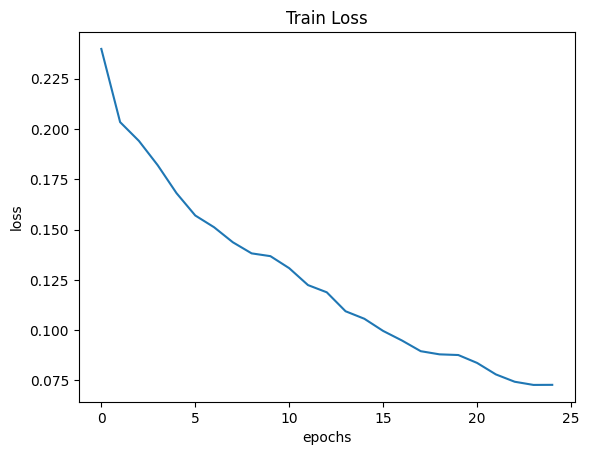

In [ ]:
plt.title('Train Loss')
plt.plot(total_train_loss)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()